In [1]:
import pandas as pd

df = pd.read_csv("data/mountains_vs_beaches_preferences.csv")

df.head()


,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,56,male,71477,bachelor,9,skiing,2477,urban,175,267,summer,0,1,1
1,69,male,88740,master,1,swimming,4777,suburban,228,190,fall,0,1,0
2,46,female,46562,master,0,skiing,1469,urban,71,280,winter,0,0,1
3,32,non-binary,99044,high school,6,hiking,1482,rural,31,255,summer,1,0,1
4,60,female,106583,high school,5,sunbathing,516,suburban,23,151,winter,1,1,0


In [2]:
from sklearn.preprocessing import StandardScaler

df = df[:10000]

Y = df.iloc[:, -1].to_numpy()
X = df.iloc[:, :-1]
X = pd.get_dummies(X).to_numpy()

X = StandardScaler().fit_transform(X)

X.shape, Y.shape


((10000, 26), (10000,))

In [3]:
import numpy as np

num_classes = len(np.unique(Y))

num_classes

2

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((8000, 26), (2000, 26), (8000,), (2000,))

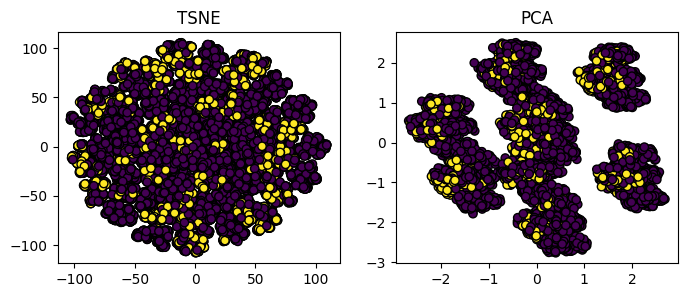

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=X)
emb_pca = PCA(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=Y, edgecolor='k')
axes[0].set_title("TSNE")

axes[1].scatter(emb_pca[:, 0], emb_pca[:, 1], c=Y, edgecolor='k')
axes[1].set_title("PCA")

plt.savefig(f"../assets/visuals.png", dpi=120, bbox_inches='tight')


In [5]:
from sklearn.metrics import classification_report
from knn import KNN, ParzenFixed, ParzenAdaptive, Simple
from pydantic import BaseModel
from tqdm import tqdm


class Scores(BaseModel):
    accuracy: float
    f1: float
    """Weighted average of f1 scores"""


def evaluate(k: int, mode: ParzenFixed | ParzenAdaptive | Simple) -> Scores:
    knn = KNN(k=k, mode=mode, num_classes=num_classes)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    report = classification_report(Y_test, Y_pred, output_dict=True)
    return Scores(accuracy=report["accuracy"], f1=report["weighted avg"]["f1-score"])


def evaluate_combinations_test(
        ks: list[int],
        modes: list[ParzenFixed | ParzenAdaptive | Simple]
) -> dict[tuple[int, str], Scores]:
    results = {}
    for k in tqdm(ks, desc="Evaluating test"):
        for mode in modes:
            results[(k, str(mode))] = evaluate(k, mode)
    return results


def evaluate_combinations_leave_one_out(
        ks: list[int],
        modes: list[ParzenFixed | ParzenAdaptive | Simple]
) -> dict[tuple[int, str], float]:
    results = {}
    for k in tqdm(ks, desc="Evaluating leave-one-out"):
        for mode in modes:
            results[(k, str(mode))] = (
                KNN(k=k, mode=mode, num_classes=num_classes)
                .fit(X_train, Y_train)
                .leave_one_out()
            )
    return results


results_leave_one_out = evaluate_combinations_leave_one_out(
    ks=[3, 30, 50, 100],
    modes=[Simple(), ParzenFixed(h=0.5), ParzenAdaptive(h=0.5)]
)

results_test = evaluate_combinations_test(
    ks=[3, 30, 50, 100],
    modes=[Simple(), ParzenFixed(h=0.5), ParzenAdaptive(h=0.5)]
)

Evaluating test: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


In [6]:
def test_results_to_md_table(results: dict[tuple[int, str], Scores]):
    rows = [
        "| k | mode | accuracy | f1 |",
        "| --- | --- | --- | --- |",
    ]
    for (k, mode), scores in results.items():
        rows.append(f"| {k} | {mode} | {scores.accuracy:.2f} | {scores.f1:.2f} |")
    return "\n".join(rows)


def leave_one_out_results_to_md_table(results: dict[tuple[int, str], float]):
    rows = [
        "| k | mode | leave-one-out error |",
        "| --- | --- | --- |",
    ]
    for (k, mode), error in results.items():
        rows.append(f"| {k} | {mode} | {error:.2f} |")
    return "\n".join(rows)

print(test_results_to_md_table(results_test))
print()
print(leave_one_out_results_to_md_table(results_leave_one_out))


| k | mode | accuracy | f1 |
| --- | --- | --- | --- |
| 3 | Simple | 0.86 | 0.86 |
| 3 | ParzenFixed(h=0.5) | 0.85 | 0.85 |
| 3 | ParzenAdaptive | 0.86 | 0.86 |
| 30 | Simple | 0.90 | 0.90 |
| 30 | ParzenFixed(h=0.5) | 0.85 | 0.85 |
| 30 | ParzenAdaptive | 0.91 | 0.91 |
| 50 | Simple | 0.91 | 0.90 |
| 50 | ParzenFixed(h=0.5) | 0.85 | 0.85 |
| 50 | ParzenAdaptive | 0.92 | 0.91 |
| 100 | Simple | 0.90 | 0.89 |
| 100 | ParzenFixed(h=0.5) | 0.85 | 0.85 |
| 100 | ParzenAdaptive | 0.90 | 0.89 |

| k | mode | leave-one-out error |
| --- | --- | --- |
| 3 | Simple | 0.15 |
| 3 | ParzenFixed(h=0.5) | 0.17 |
| 3 | ParzenAdaptive | 0.15 |
| 30 | Simple | 0.10 |
| 30 | ParzenFixed(h=0.5) | 0.17 |
| 30 | ParzenAdaptive | 0.09 |
| 50 | Simple | 0.09 |
| 50 | ParzenFixed(h=0.5) | 0.17 |
| 50 | ParzenAdaptive | 0.08 |
| 100 | Simple | 0.10 |
| 100 | ParzenFixed(h=0.5) | 0.17 |
| 100 | ParzenAdaptive | 0.10 |


In [7]:
results_parzen_adaptive_test = evaluate_combinations_test(
    ks=[3, 30, 50, 100],
    modes=[ParzenAdaptive()]
)

results_parzen_adaptive_leave_one_out = evaluate_combinations_leave_one_out(
    ks=[3, 30, 50, 100],
    modes=[ParzenAdaptive()]
)


Evaluating leave-one-out: 100%|██████████| 4/4 [00:30<00:00,  7.52s/it]


NameError: name 'plt' is not defined

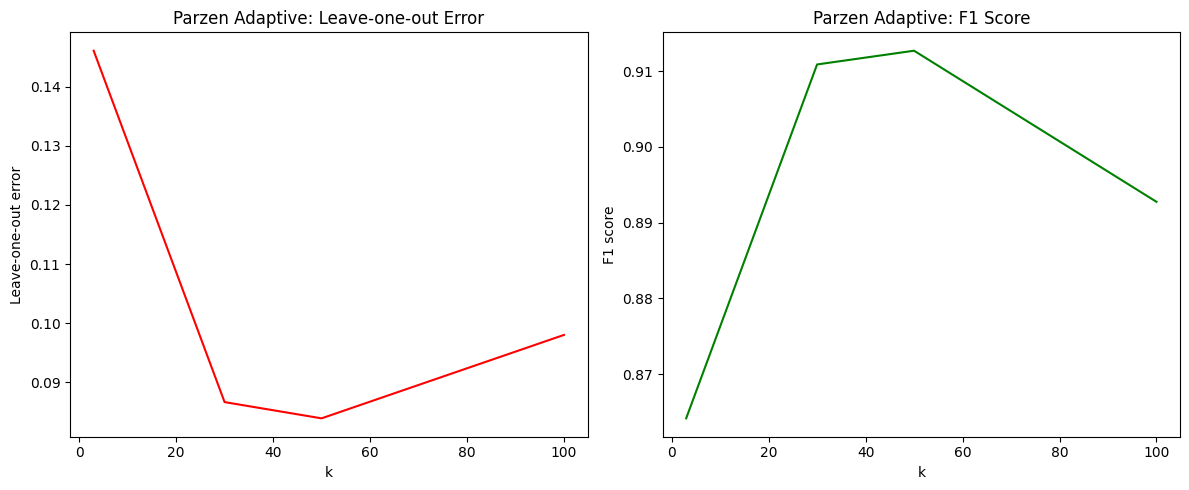

In [15]:
import matplotlib.pyplot as plt


def plot_parzen_adaptive_results(leave_one_out_results: dict[tuple[int, str], float], test_results: dict[tuple[int, str], Scores]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left plot: Leave-one-out results
    k_values_loo = sorted([k for (k, _) in leave_one_out_results.keys()])
    errors = [leave_one_out_results[(k, 'ParzenAdaptive')] for k in k_values_loo]
    ax1.plot(k_values_loo, errors, color='red')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Leave-one-out error')
    ax1.set_title('Parzen Adaptive: Leave-one-out Error')
    
    # Right plot: Test results
    k_values_test = sorted([k for (k, _) in test_results.keys()])
    f1_scores = [test_results[(k, 'ParzenAdaptive')].f1 for k in k_values_test]
    ax2.plot(k_values_test, f1_scores, color='green')
    ax2.set_xlabel('k')
    ax2.set_ylabel('F1 score')
    ax2.set_title('Parzen Adaptive: F1 Score')
    
    plt.tight_layout()
    plt.savefig("../assets/parzen_adaptive_results.png", dpi=120, bbox_inches='tight')
    plt.show()

plot_parzen_adaptive_results(results_parzen_adaptive_leave_one_out, results_parzen_adaptive_test)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
import time

ks = [3, 30, 50]
results = []

for k in ks:
    # Measure sklearn implementation time
    knn = KNeighborsClassifier(n_neighbors=k)
    start_time = time.time()
    knn.fit(X_train, Y_train)
    accuracy_sklearn = knn.score(X_test, Y_test)
    sklearn_time = time.time() - start_time

    # Measure custom implementation time
    start_time = time.time()
    accuracy_parzen_adaptive = evaluate(k=k, mode=ParzenAdaptive()).accuracy
    custom_time = time.time() - start_time
    
    results.append({
        'k': k,
        'sklearn_time': sklearn_time,
        'custom_time': custom_time,
        'sklearn_accuracy': accuracy_sklearn,
        'custom_accuracy': accuracy_parzen_adaptive
    })

print("| k | sklearn time (s) | custom time (s) | sklearn accuracy | custom accuracy |")
print("|---|-----------------|-----------------|------------------|-----------------|")
for r in results:
    print(f"| {r['k']} | {r['sklearn_time']:.3f} | {r['custom_time']:.3f} | {r['sklearn_accuracy']:.3f} | {r['custom_accuracy']:.3f} |")


| k | sklearn time (s) | custom time (s) | sklearn accuracy | custom accuracy |
|---|-----------------|-----------------|------------------|-----------------|
| 3 | 0.019 | 1.598 | 0.865 | 0.865 |
| 30 | 0.030 | 1.557 | 0.903 | 0.914 |
| 50 | 0.035 | 1.548 | 0.909 | 0.917 |
